# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

tf.random.set_seed(1234)

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
train_features = [idx for idx in range(784)]

In [3]:
# Network hyperparameters
BATCH_SIZE = 1024
EPOCHS = 1000

# Adam hyperparameters as recommended by arXiv:1704.00028
# Discriminator learning rate has been lowered to discourage mode collapse
LEARNING_RATE_GEN = 1e-4
LEARNING_RATE_DISC = 1e-5
BETA_1 = 0
BETA_2 = 0.9

# WGAN hyperparameters
N_CRITIC = 5
C_LAMBDA = 10

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = np.delete(train_images, [i for i in range(train_images.shape[0] % (BATCH_SIZE * 4))], axis = 0)
train_labels = np.delete(train_labels, [i for i in range(train_labels.shape[0] % (BATCH_SIZE * 4))], axis = 0)

train_images = train_images.reshape(train_images.shape[0], 784).astype('float32')

scaler = MinMaxScaler((-1,1)).fit(train_images)
train_images = scaler.transform(train_images)

In [5]:
X_train, X_test = train_test_split(train_images, test_size = 0.25, random_state = 1234)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

Dataset consists of 42 batches of 1024 samples each, total 43008 samples
Testset consists of 14 batches of 1024 samples each, total 14336 samples


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [8]:
generator = make_generator_model()

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [10]:
discriminator = make_discriminator_model()

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                39250     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [13]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [14]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [15]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_GEN, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_DISC, beta_1=BETA_1, beta_2=BETA_2)

In [17]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [18]:
@tf.function
def train_step_generator():
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [19]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [20]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [21]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [22]:
def graph_gan(generator):
    # realdata = scaler.inverse_transform(X_train)
    fakedata = scaler.inverse_transform(generator(tf.random.normal((1, len(train_features))), training=False))

    fakedata = fakedata.reshape((28, 28))

    plt.imshow(fakedata)
    plt.show()

In [23]:
def graph_pixel(generator):
    realdata = scaler.inverse_transform(X_train)
    fakedata = scaler.inverse_transform(generator(tf.random.normal((1000, len(train_features))), training=False))

    realavg = np.average(realdata, axis = 1)
    fakeavg = np.average(fakedata, axis = 1)

    plt.title("Average pixel intensity")
    plt.ylabel("Normalized to Unity")
    plt.xlabel("Pixel intensity")
    plt.hist(fakeavg, bins = 25, range = (0,255), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.hist(realavg, bins = 25, range = (0,255), color = "tab:orange", alpha = 0.5, label = "MNIST", density = True)
    plt.legend()
    plt.show()

In [24]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [25]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [26]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [27]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = False # ((epoch + 1) % 1 == 0)
    draw_outputs = ((epoch + 1) % 25 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for batchnum, image_batch in enumerate(dataset):
      if random.random() < 1 / n_critic:
        train_gen_loss += K_eval(train_step_generator()) / len_dataset * n_critic
      train_disc_loss += K_eval(train_step_discriminator(image_batch)) / len_dataset
    
    train_gen_losses.append(train_gen_loss)
    train_disc_losses.append(train_disc_loss)

    # Evaluation

    for batchnum, test_batch in enumerate(testset):
      test_gen_loss += K_eval(evaluate_generator()) / len_testset
      test_disc_loss += K_eval(evaluate_discriminator(test_batch)) / len_testset

    test_gen_losses.append(test_gen_loss)
    test_disc_losses.append(test_disc_loss)

    # Logging

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)
      graph_pixel(generator)
      graph_genloss()
      graph_discloss()

  2%|▏         | 24/1000 [00:17<09:30,  1.71it/s]
Epoch 25:


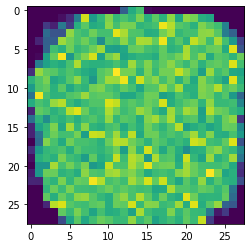

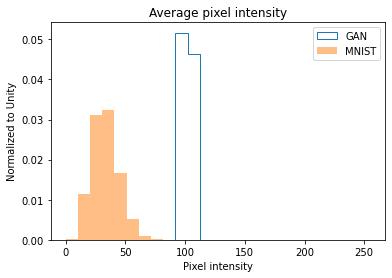

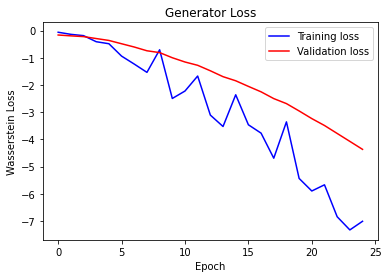

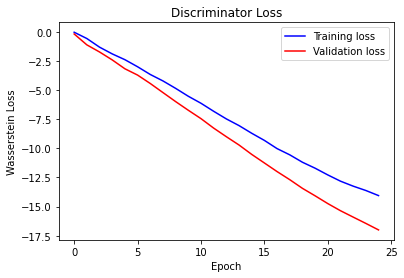

  5%|▍         | 49/1000 [00:33<09:39,  1.64it/s]
Epoch 50:


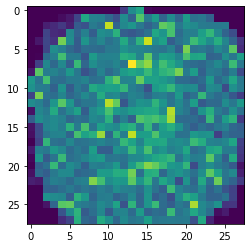

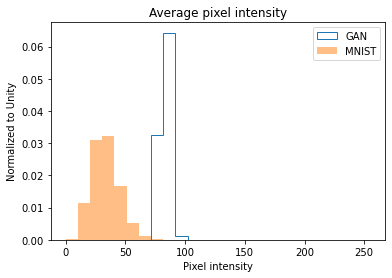

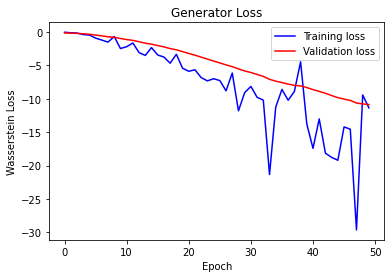

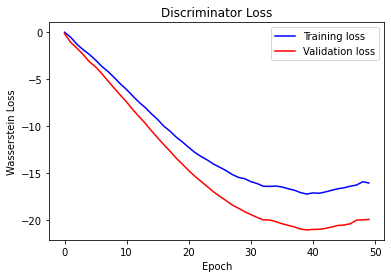

  7%|▋         | 74/1000 [00:49<09:15,  1.67it/s]
Epoch 75:


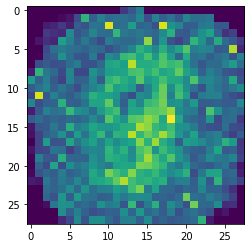

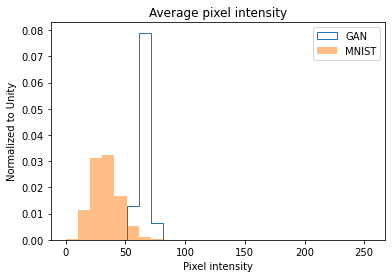

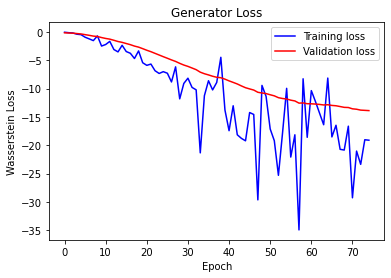

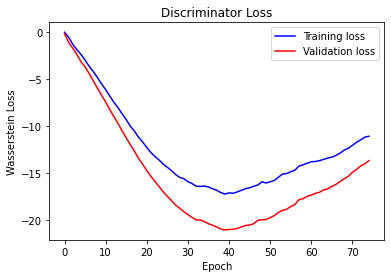

 10%|▉         | 99/1000 [01:05<08:57,  1.68it/s]
Epoch 100:


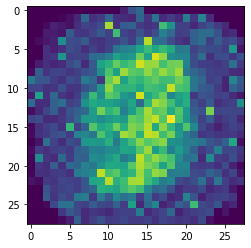

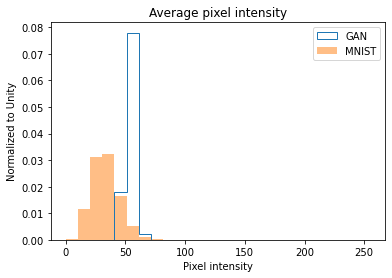

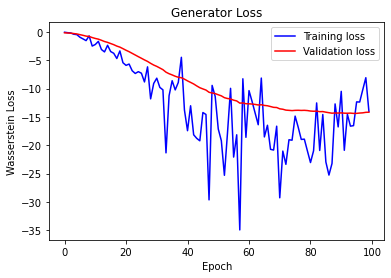

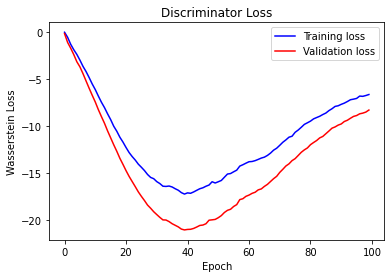

 12%|█▏        | 124/1000 [01:21<08:30,  1.72it/s]
Epoch 125:


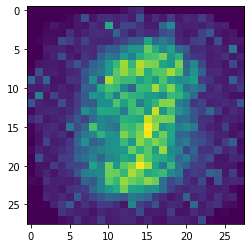

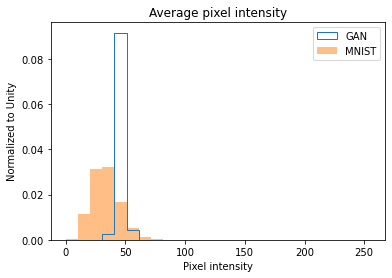

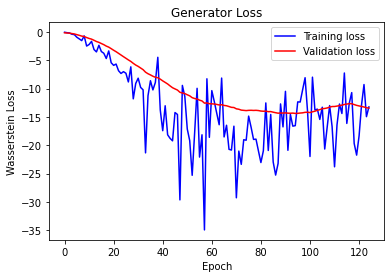

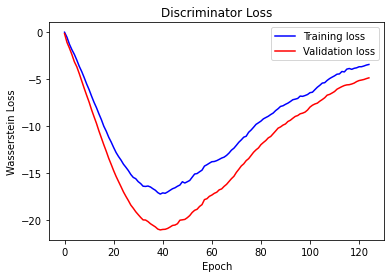

 15%|█▍        | 149/1000 [01:36<08:09,  1.74it/s]
Epoch 150:


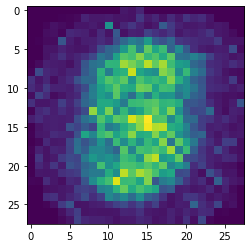

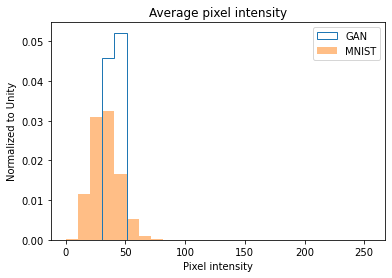

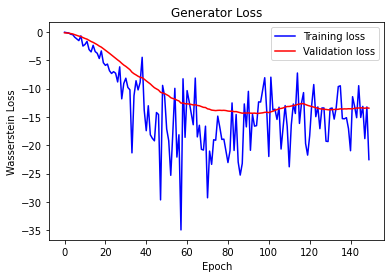

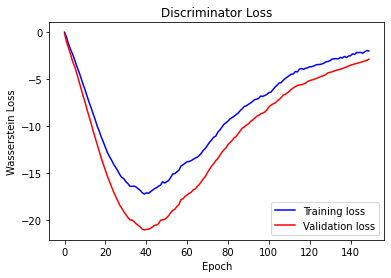

 17%|█▋        | 174/1000 [01:53<08:23,  1.64it/s]
Epoch 175:


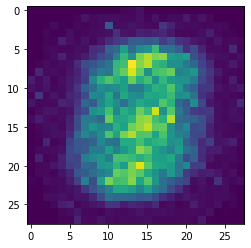

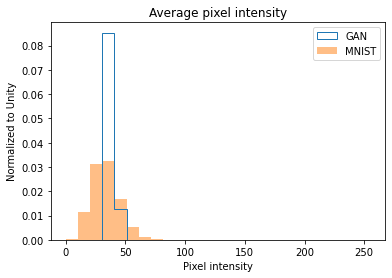

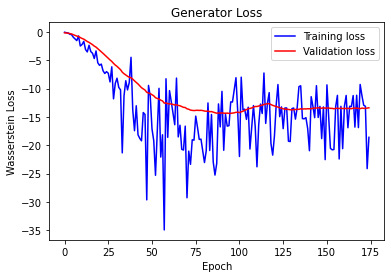

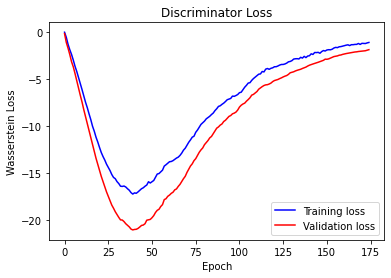

 20%|█▉        | 199/1000 [02:09<07:35,  1.76it/s]
Epoch 200:


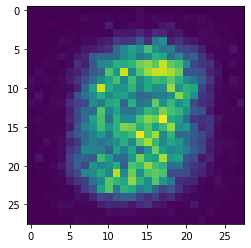

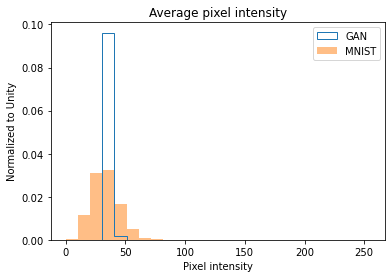

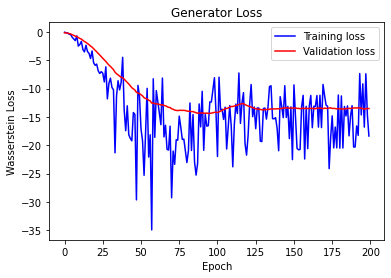

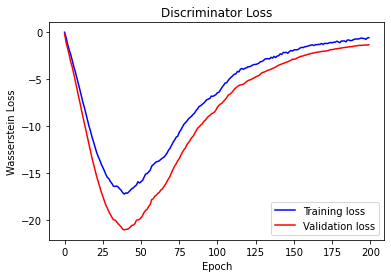

 22%|██▏       | 224/1000 [02:25<07:27,  1.74it/s]
Epoch 225:


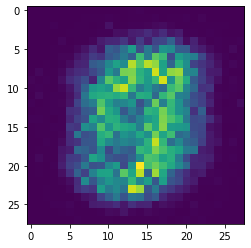

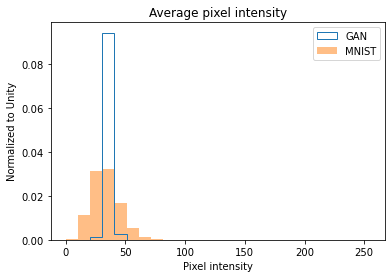

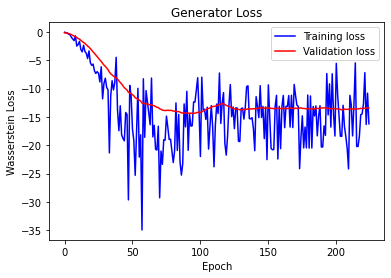

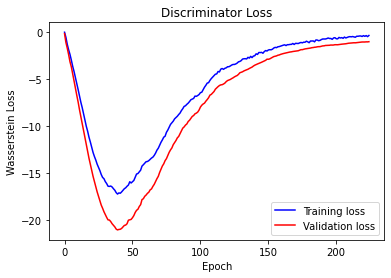

 25%|██▍       | 249/1000 [02:41<07:29,  1.67it/s]
Epoch 250:


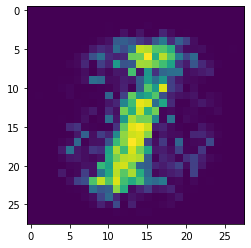

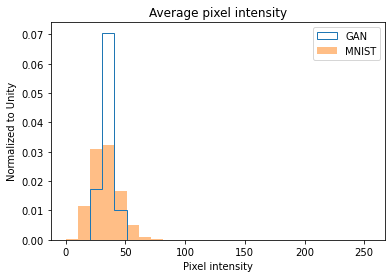

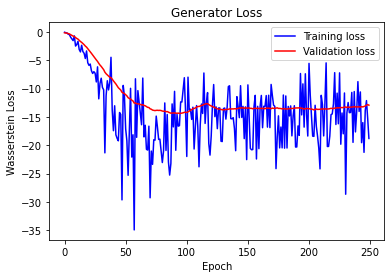

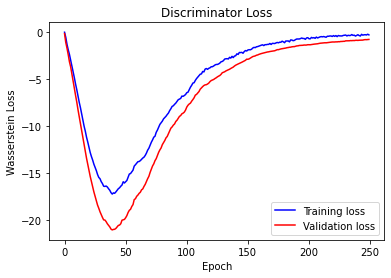

 27%|██▋       | 274/1000 [02:58<07:25,  1.63it/s]
Epoch 275:


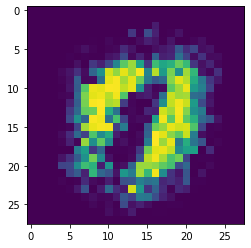

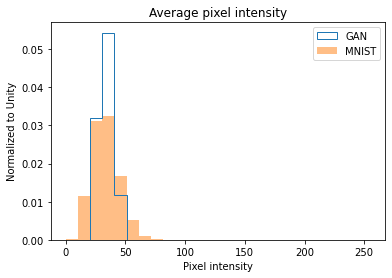

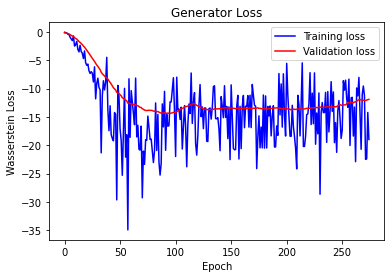

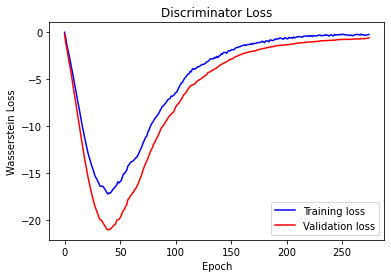

 30%|██▉       | 299/1000 [03:14<06:56,  1.68it/s]
Epoch 300:


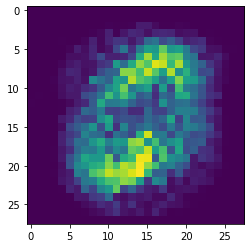

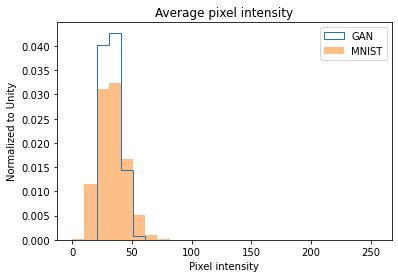

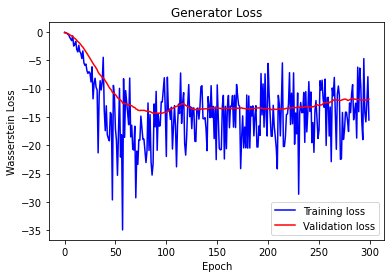

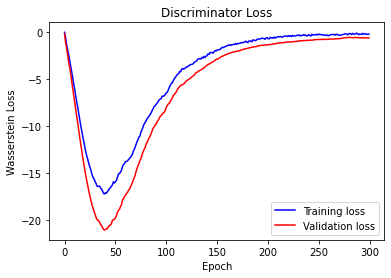

 32%|███▏      | 324/1000 [03:30<06:53,  1.64it/s]
Epoch 325:


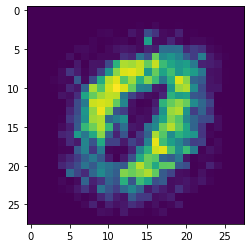

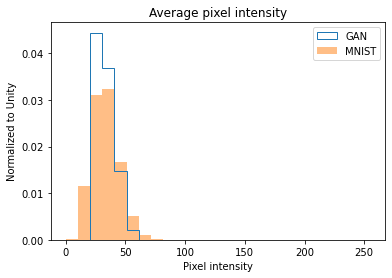

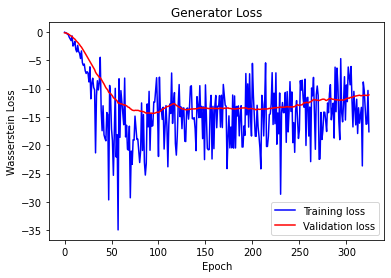

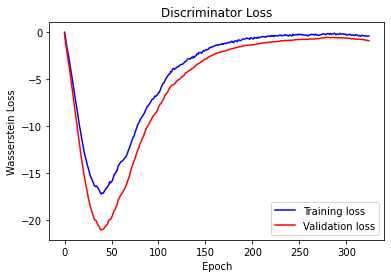

 35%|███▍      | 349/1000 [03:46<06:26,  1.68it/s]
Epoch 350:


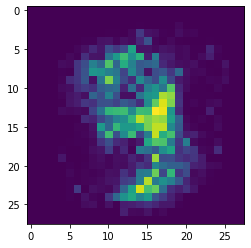

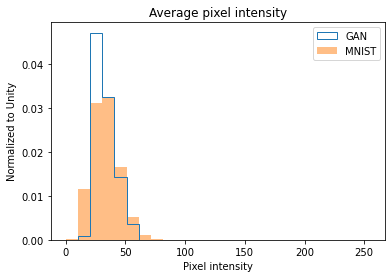

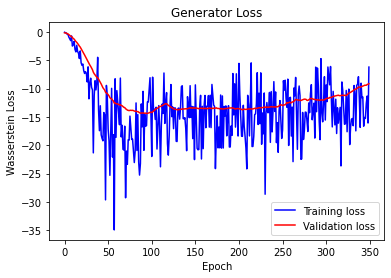

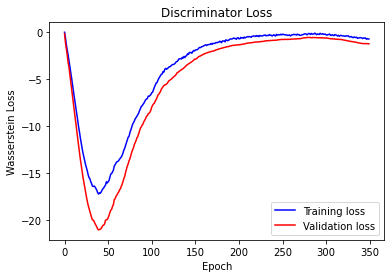

 37%|███▋      | 374/1000 [04:03<06:09,  1.69it/s]
Epoch 375:


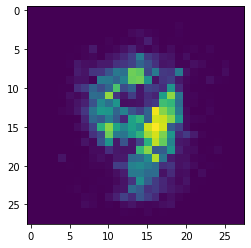

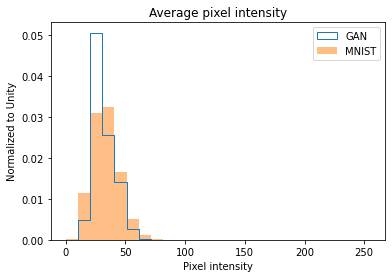

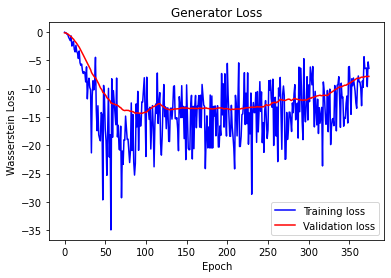

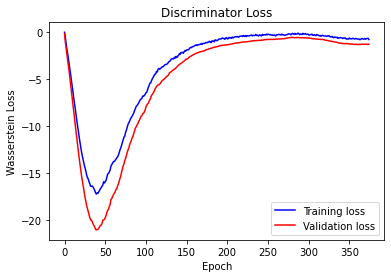

 40%|███▉      | 399/1000 [04:19<06:10,  1.62it/s]
Epoch 400:


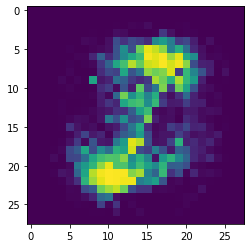

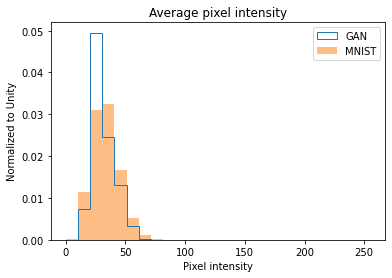

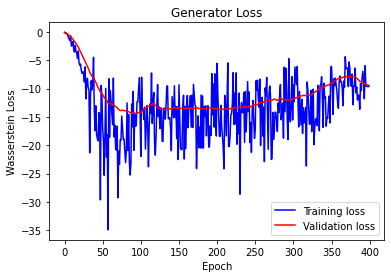

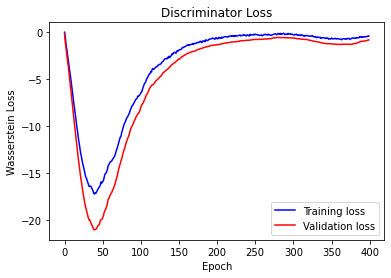

 42%|████▏     | 424/1000 [04:36<05:40,  1.69it/s]
Epoch 425:


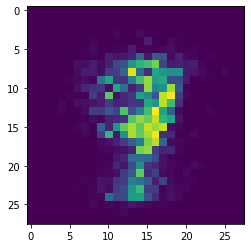

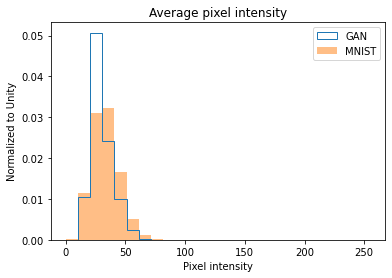

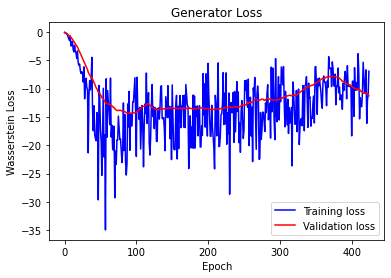

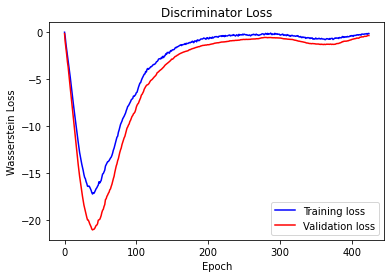

 45%|████▍     | 449/1000 [04:52<05:34,  1.65it/s]
Epoch 450:


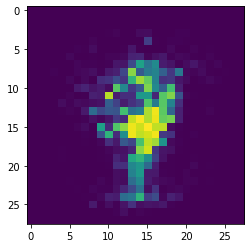

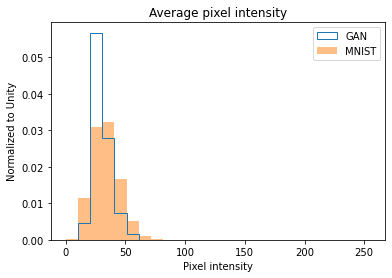

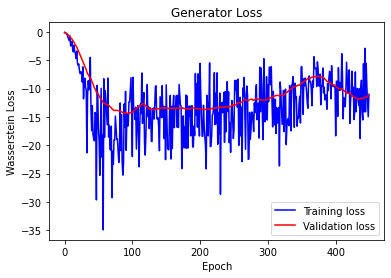

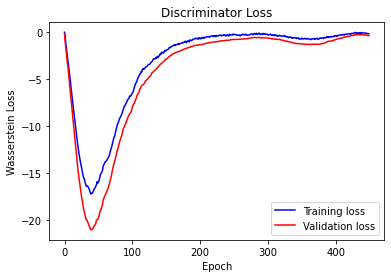

 47%|████▋     | 474/1000 [05:09<05:44,  1.53it/s]
Epoch 475:


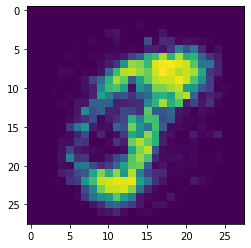

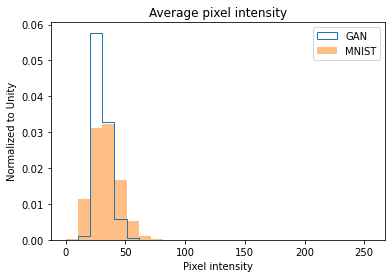

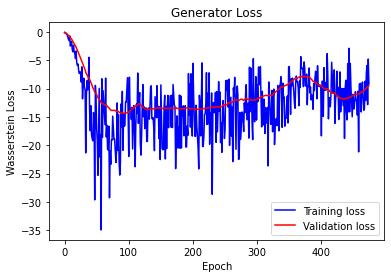

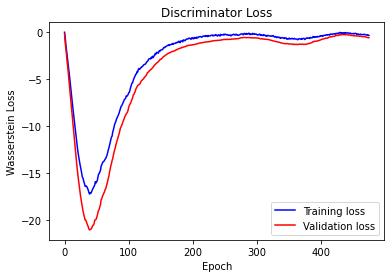

 50%|████▉     | 499/1000 [05:27<05:15,  1.59it/s]
Epoch 500:


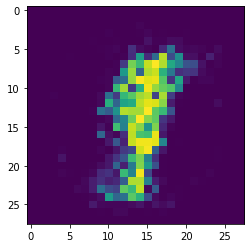

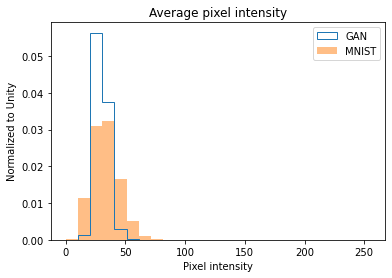

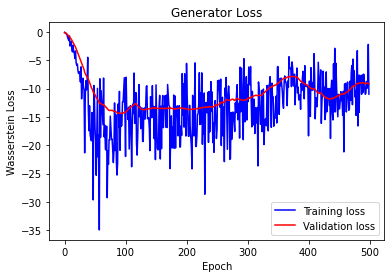

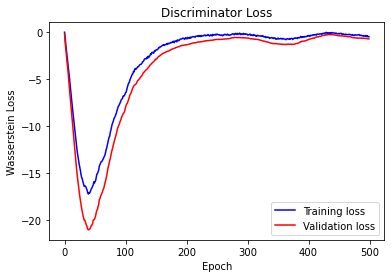

 52%|█████▏    | 524/1000 [05:44<05:14,  1.51it/s]
Epoch 525:


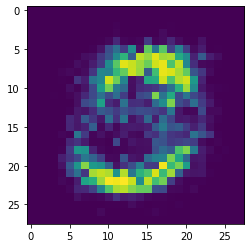

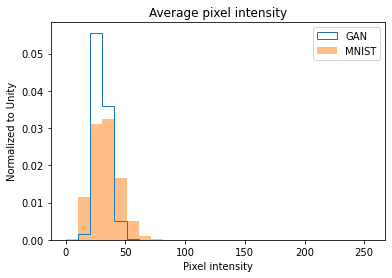

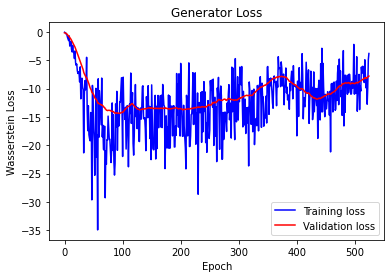

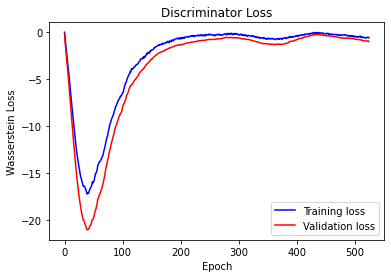

 55%|█████▍    | 549/1000 [06:01<04:37,  1.63it/s]
Epoch 550:


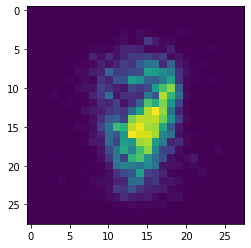

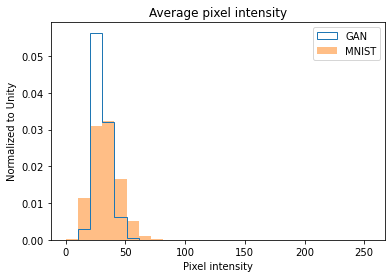

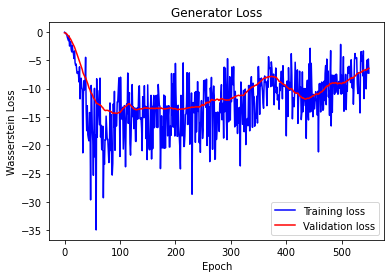

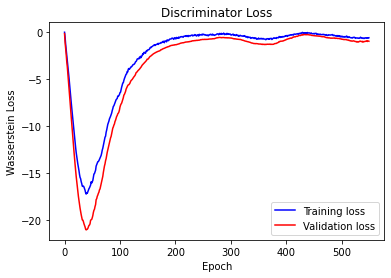

 57%|█████▋    | 574/1000 [06:20<04:51,  1.46it/s]
Epoch 575:


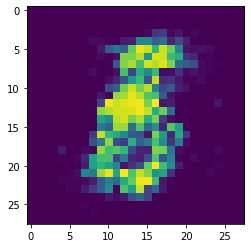

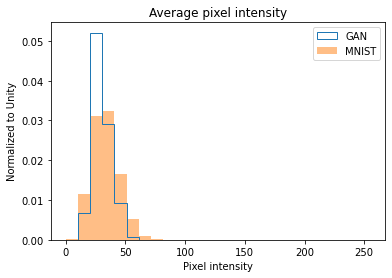

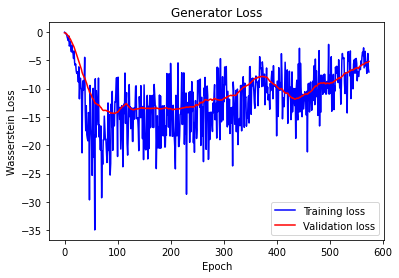

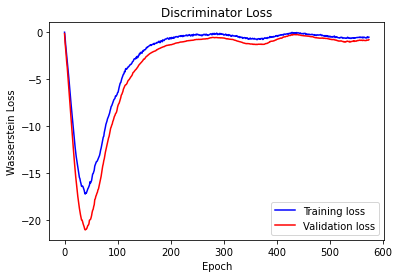

 60%|█████▉    | 599/1000 [06:37<04:16,  1.57it/s]
Epoch 600:


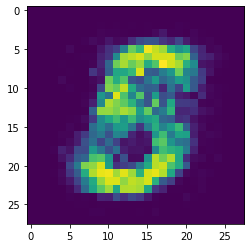

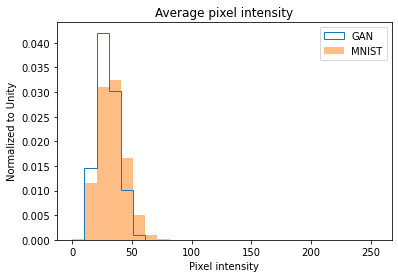

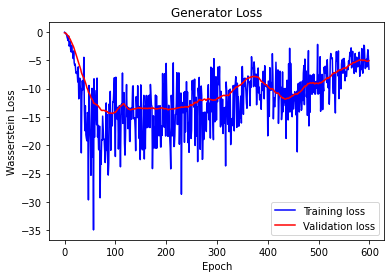

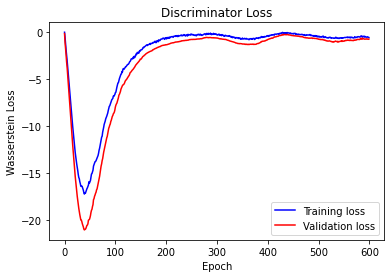

 62%|██████▏   | 624/1000 [06:55<03:47,  1.65it/s]
Epoch 625:


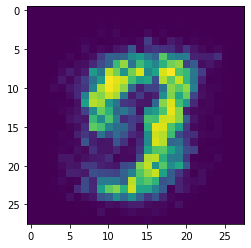

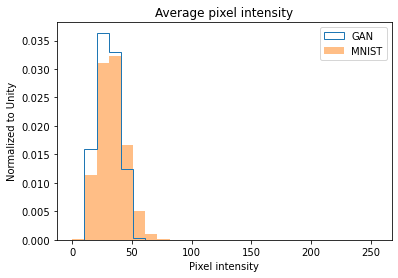

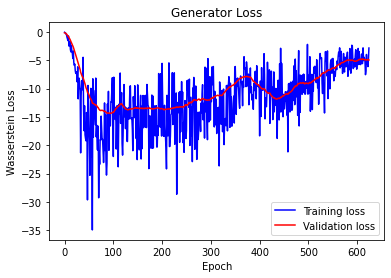

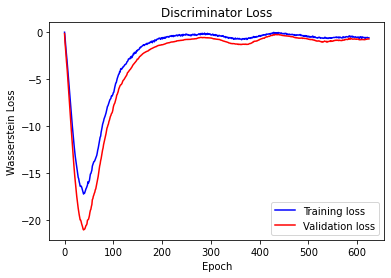

 65%|██████▍   | 649/1000 [07:14<03:55,  1.49it/s]
Epoch 650:


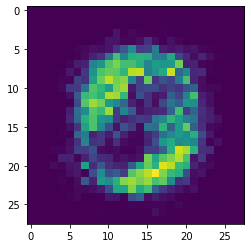

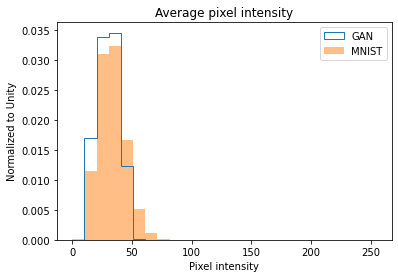

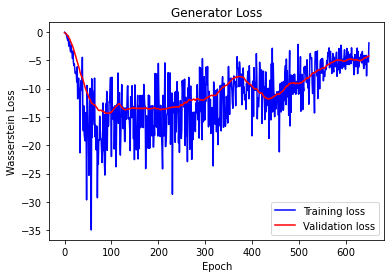

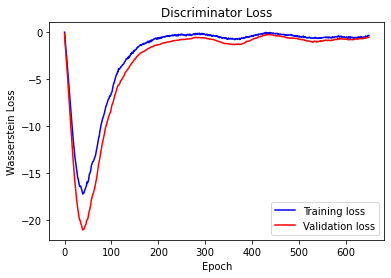

 67%|██████▋   | 674/1000 [07:31<03:37,  1.50it/s]
Epoch 675:


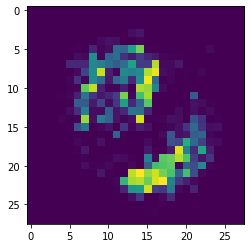

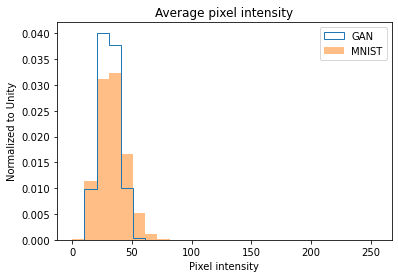

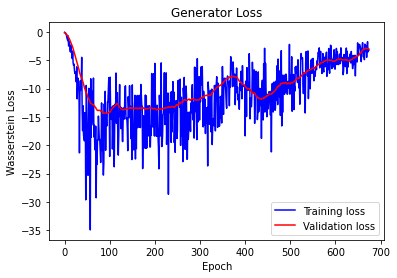

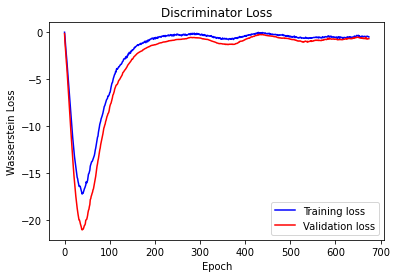

 70%|██████▉   | 699/1000 [07:48<03:08,  1.59it/s]
Epoch 700:


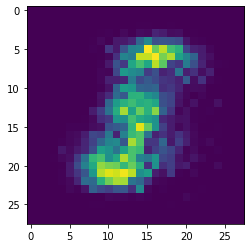

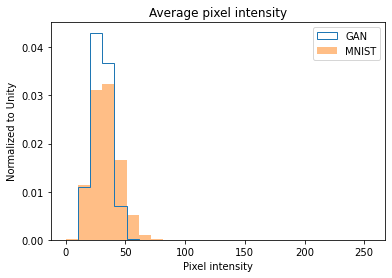

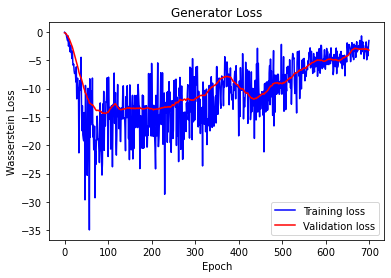

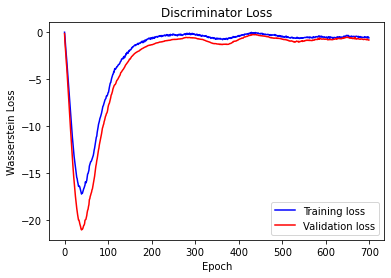

 72%|███████▏  | 724/1000 [08:05<02:51,  1.61it/s]
Epoch 725:


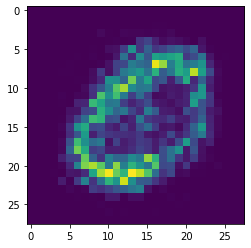

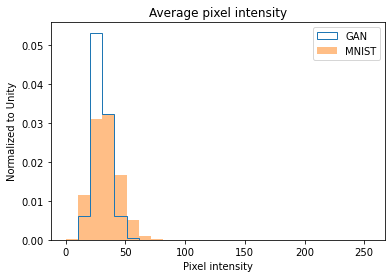

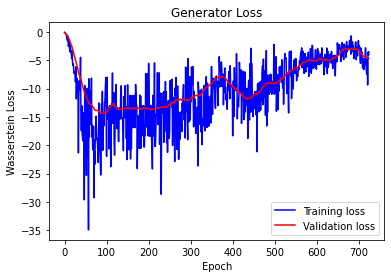

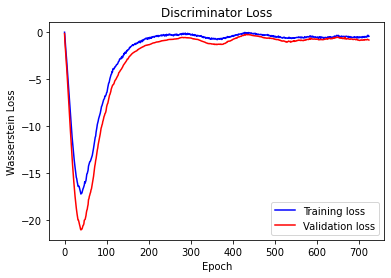

 75%|███████▍  | 749/1000 [08:23<03:14,  1.29it/s]
Epoch 750:


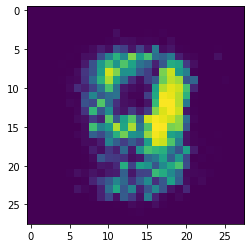

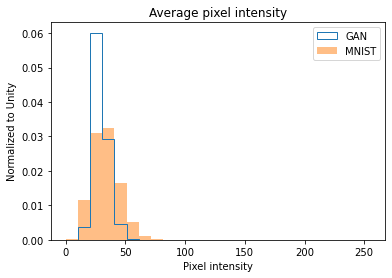

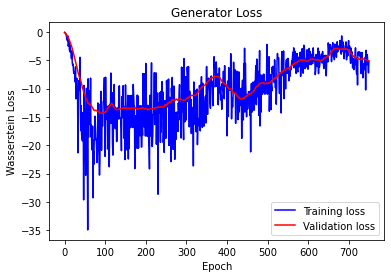

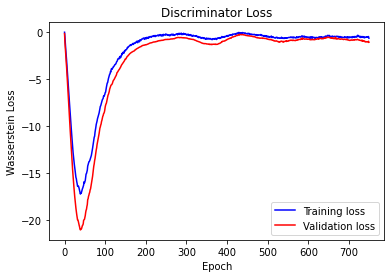

 77%|███████▋  | 774/1000 [08:41<02:17,  1.64it/s]
Epoch 775:


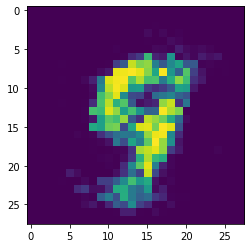

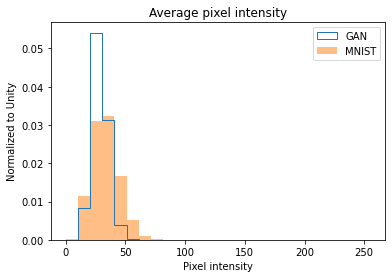

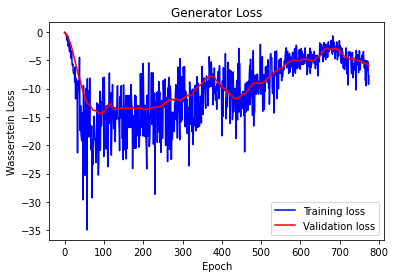

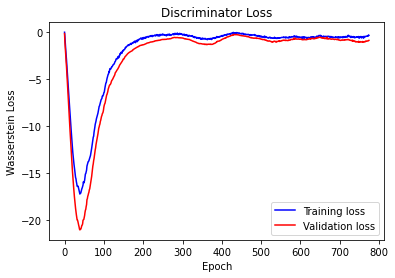

 80%|███████▉  | 799/1000 [08:58<02:09,  1.56it/s]
Epoch 800:


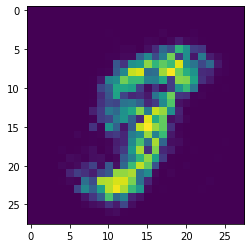

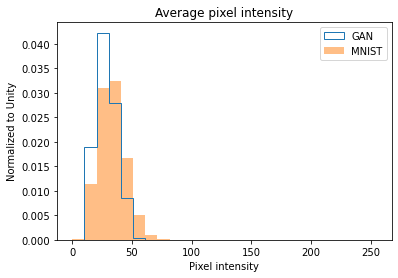

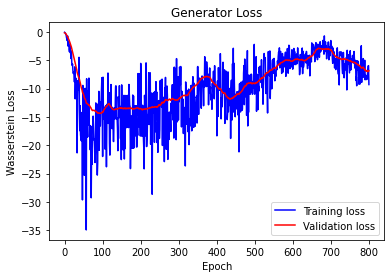

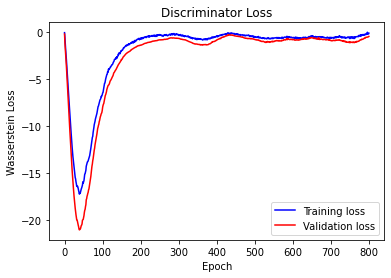

 82%|████████▏ | 824/1000 [09:14<01:39,  1.76it/s]
Epoch 825:


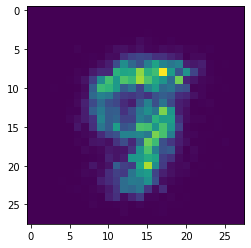

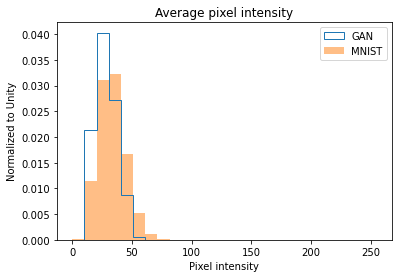

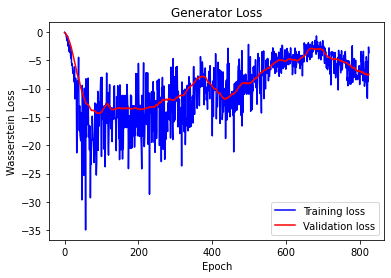

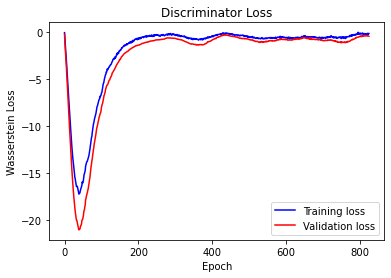

 85%|████████▍ | 849/1000 [09:30<01:38,  1.53it/s]
Epoch 850:


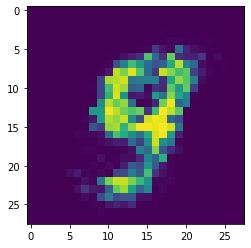

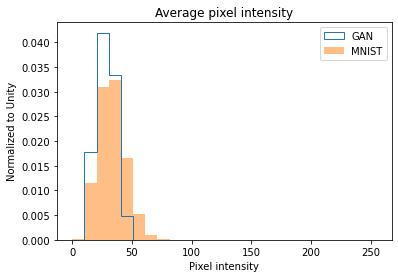

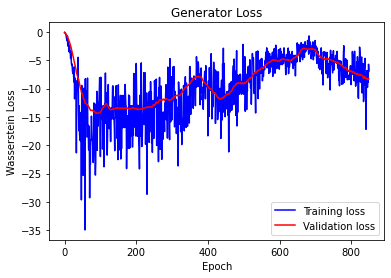

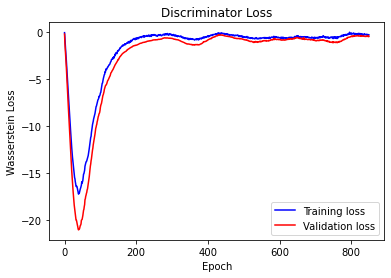

 87%|████████▋ | 874/1000 [09:47<01:16,  1.64it/s]
Epoch 875:


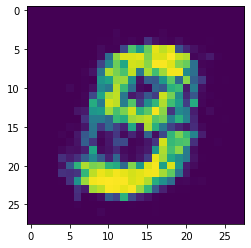

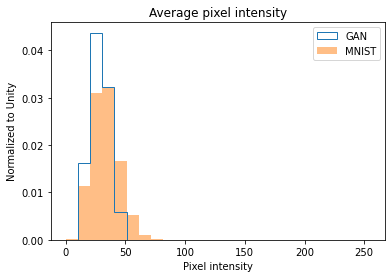

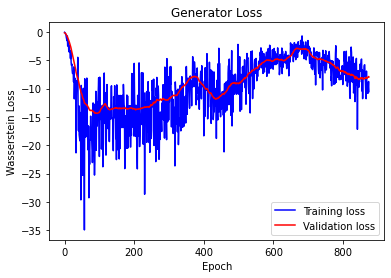

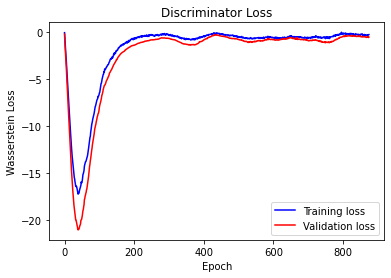

 90%|████████▉ | 899/1000 [10:04<01:02,  1.62it/s]
Epoch 900:


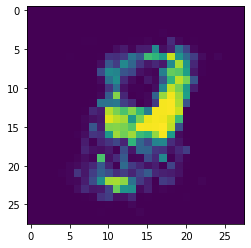

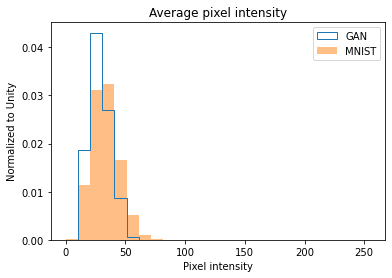

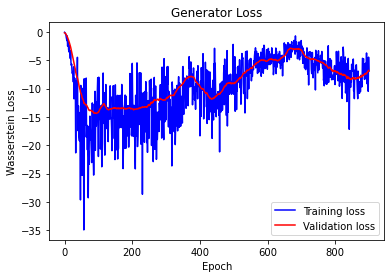

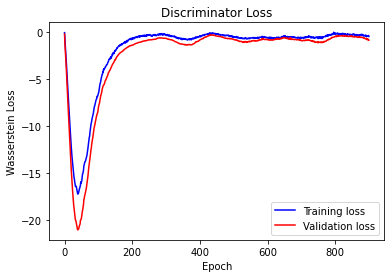

 92%|█████████▏| 924/1000 [10:21<00:50,  1.52it/s]
Epoch 925:


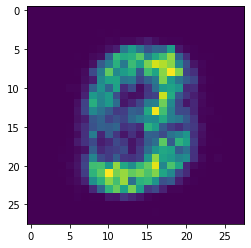

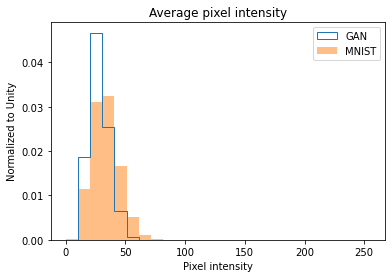

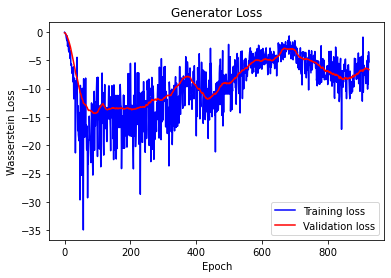

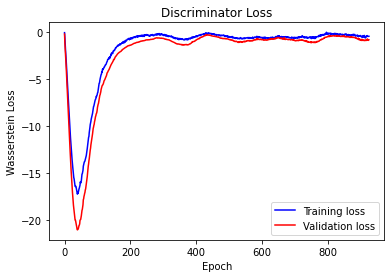

 95%|█████████▍| 949/1000 [10:38<00:33,  1.54it/s]
Epoch 950:


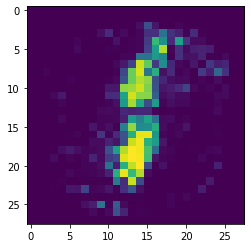

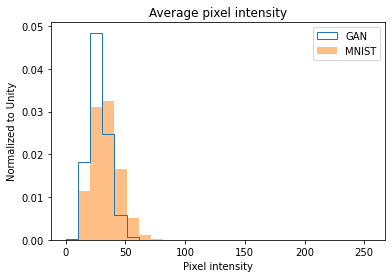

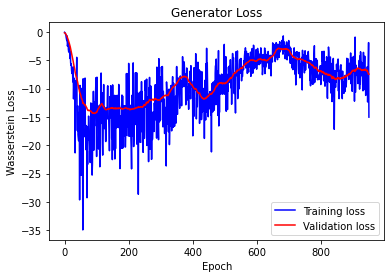

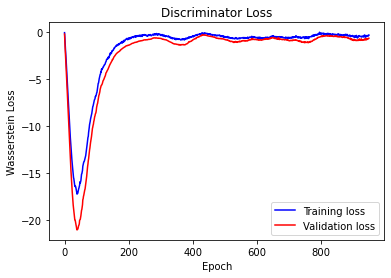

 97%|█████████▋| 974/1000 [10:57<00:17,  1.53it/s]
Epoch 975:


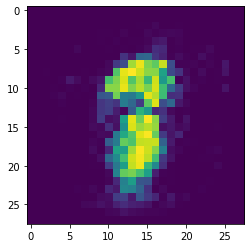

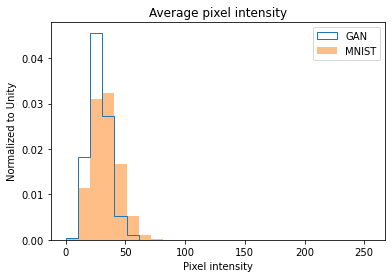

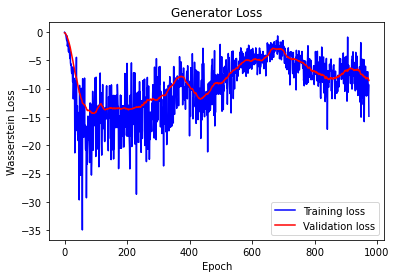

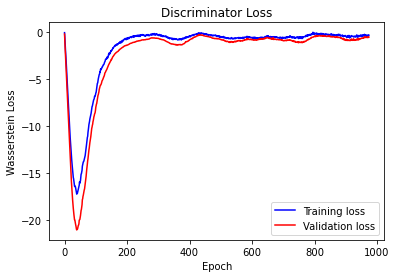

100%|█████████▉| 999/1000 [11:16<00:00,  1.43it/s]
Epoch 1000:


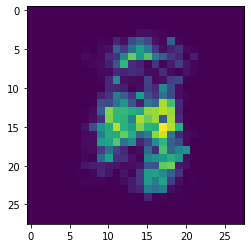

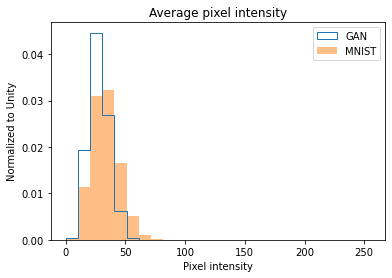

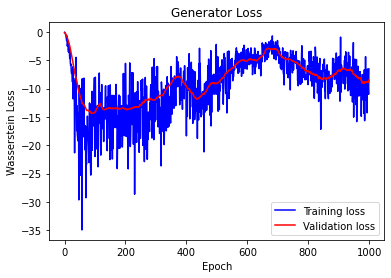

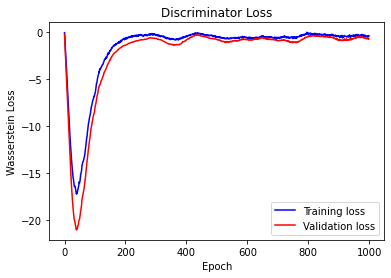

100%|██████████| 1000/1000 [11:18<00:00,  1.47it/s]


In [28]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)

## Results
???